In [5]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sijovm/atpdata")

# print("Path to dataset files:", path)

In [16]:
import sys
print(sys.version)

3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]


In [6]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
from plotnine import ggplot, aes, geom_tile, scale_fill_gradient, theme_minimal, theme, geom_boxplot
from plotnine import ggsave, scale_y_reverse, labs, scale_fill_gradient2,geom_line,geom_point,scale_color_manual,geom_text
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,roc_curve, auc
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
import xgboost as xgb
from tqdm import tqdm

In [7]:
data = pd.read_csv("atp_matches_till_2022.csv")

In [8]:
data['tourney_yr']  = data['tourney_id'].apply(lambda x: x.split('-')[0]).astype(int)
data = data.loc[data['tourney_yr'] >= 1991]

In [9]:
data_win = data[['winner_id','winner_name','surface','winner_ht','winner_age','w_ace', 'w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_bpSaved','w_bpFaced']].dropna()
data_lose = data[['loser_id','loser_name','surface','loser_ht','loser_age','l_ace', 'l_df','l_svpt','l_1stIn','l_1stWon','l_2ndWon','l_bpSaved','l_bpFaced']].dropna()
data_win.columns = [col.split('_', 1)[1] if '_' in col else col for col in data_win.columns]
data_lose.columns = [col.split('_', 1)[1] if '_' in col else col for col in data_lose.columns]
data_win['win'] = 1
data_lose['win'] = 0

In [10]:
dataset = pd.concat([data_win, data_lose], axis=0)
dataset = dataset.sample(n=10000, random_state=42).reset_index(drop=True)

In [11]:
dataset.describe()

,id,ht,age,ace,df,svpt,1stIn,1stWon,2ndWon,bpSaved,bpFaced,win
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,106015.860700,185.425900,25.967420,5.591200,3.120200,79.364800,47.773800,33.860100,15.775600,4.147000,6.944000,0.504400
std,14172.725522,6.581918,3.818011,5.026869,2.534402,29.402047,19.260268,14.237858,7.057792,3.248484,4.443674,0.500006
min,100284.000000,168.000000,16.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,102110.000000,180.000000,23.200000,2.000000,1.000000,58.000000,34.000000,24.000000,11.000000,2.000000,4.000000,0.000000
50%,103507.000000,185.000000,25.700000,4.000000,3.000000,74.000000,44.000000,31.000000,15.000000,4.000000,6.000000,1.000000
75%,104745.000000,190.000000,28.600000,8.000000,4.000000,95.000000,58.000000,41.000000,20.000000,6.000000,10.000000,1.000000
max,210013.000000,211.000000,41.600000,75.000000,20.000000,240.000000,170.000000,127.000000,60.000000,24.000000,31.000000,1.000000


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   name     10000 non-null  object 
 2   surface  10000 non-null  object 
 3   ht       10000 non-null  float64
 4   age      10000 non-null  float64
 5   ace      10000 non-null  float64
 6   df       10000 non-null  float64
 7   svpt     10000 non-null  float64
 8   1stIn    10000 non-null  float64
 9   1stWon   10000 non-null  float64
 10  2ndWon   10000 non-null  float64
 11  bpSaved  10000 non-null  float64
 12  bpFaced  10000 non-null  float64
 13  win      10000 non-null  int64  
dtypes: float64(10), int64(2), object(2)
memory usage: 1.1+ MB


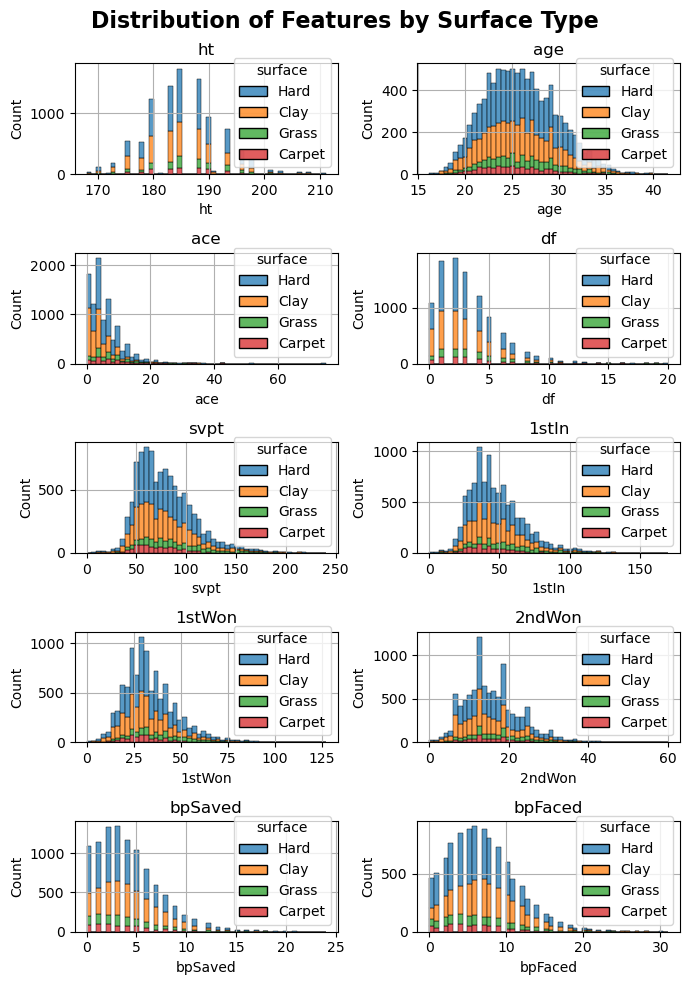

In [13]:

numeric_cols = dataset.drop(columns=['id', 'name', 'win', 'surface']).columns

# Create a 2x5 grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7, 10))
axes = axes.flatten()  # Flatten the 2D array for easy iteration

# Plot each histogram
for i, col in enumerate(numeric_cols):
    sns.histplot(data=dataset, x=col, bins=50, hue="surface", hue_order = ['Hard','Clay','Grass','Carpet'], ax=axes[i],multiple="stack")
    axes[i].set_title(col)
    axes[i].grid(True)


fig.suptitle("Distribution of Features by Surface Type", fontsize=16, fontweight='bold')
plt.tight_layout()


plt.savefig("Distribution_of_Features_by_Surface_Type.png", format="png", dpi=500)
plt.show()

In [9]:
le = LabelEncoder()
dataset['surface_num'] = le.fit_transform(dataset['surface'])

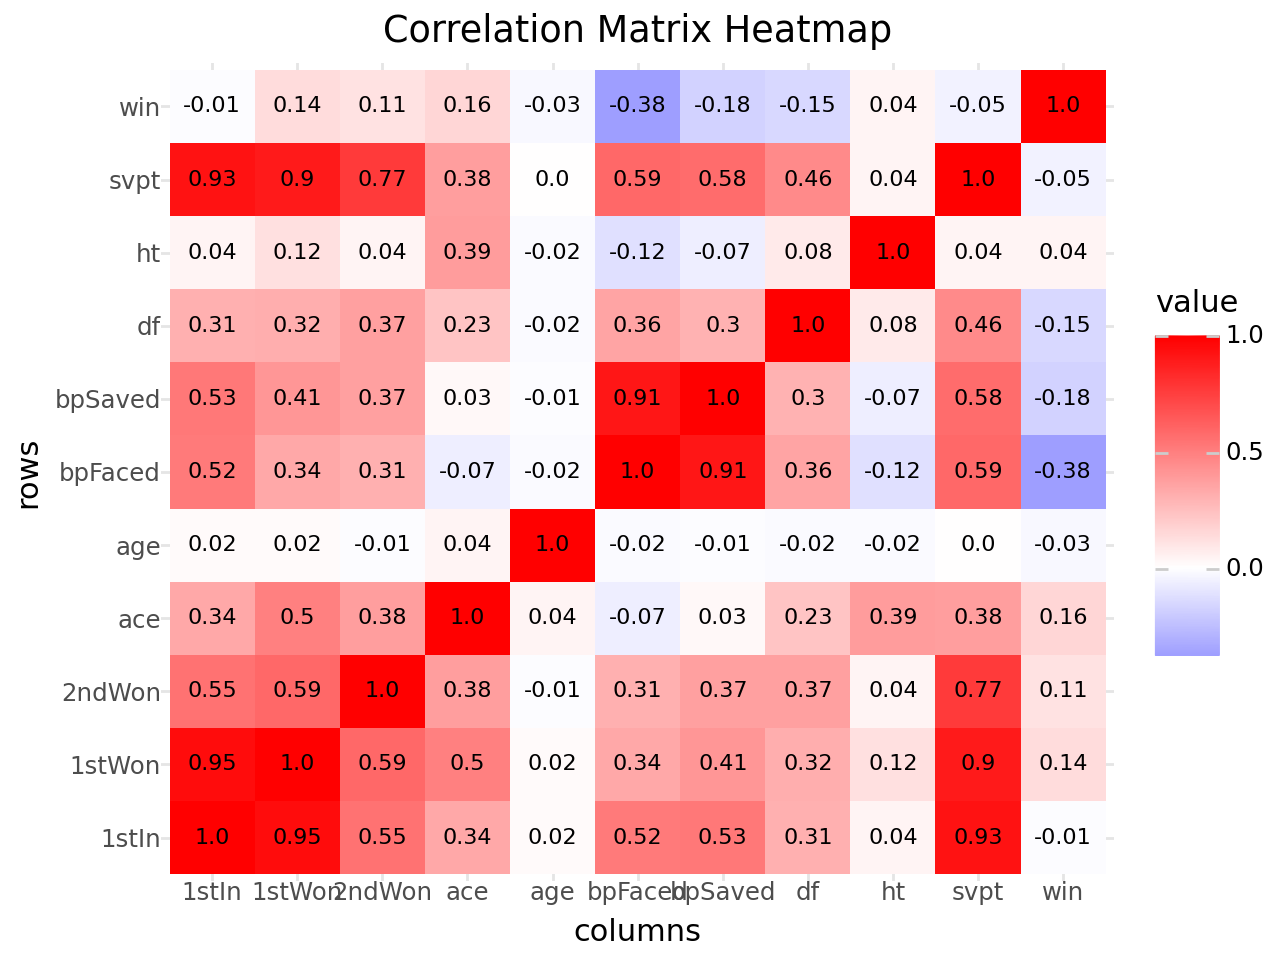

C:\Users\mmcdo\miniconda3\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 7.5 x 5 in image.
C:\Users\mmcdo\miniconda3\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: correlation_matrix.png


In [36]:
corr = dataset.drop(columns=['id', 'name', 'surface']).corr().round(2).reset_index().melt(id_vars="index", var_name="columns", value_name="value")

corr = corr.rename(columns={"index": "rows"})

plot = (ggplot(corr, aes(x='columns', y='rows', fill='value'))
        + geom_tile()
        + scale_fill_gradient2(low="blue", high="red", mid="white", midpoint=0)
        + geom_text(aes(label='value'), color='black', size=8)
        + theme_minimal()
        + labs(title="Correlation Matrix Heatmap")
       )

#plot.tight_layout()
plot.show()
ggsave(plot, filename='correlation_matrix.png', width=7.5, height=5)

In [11]:
data = dataset.drop(columns=['id', 'name', 'surface'])
response = data[['win']]
features = data.drop(columns=['win'])
train_size = round(len(data)*0.9)
test_size = round(len(data)*0.1)

train_features, test_features, train_response, test_response = train_test_split(
  features, response, train_size = train_size , test_size = test_size, random_state=123)


train_data = pd.concat([train_response, train_features], axis=1)
test_data = pd.concat([test_response, test_features], axis=1)

In [12]:
def standardize_data(features,response):
    
  
  #scale dataset
  feautre_scaler = StandardScaler()
  response_scaler = StandardScaler()
  feautre_scaler.fit(features)
  response_scaler.fit(response)
  
  features_scaled = feautre_scaler.transform(features) #scaled Features
  response_scaled = response_scaler.transform(response) # scaled Response

  
  
  features_scaled = pd.DataFrame(features_scaled, columns=features.columns)
  response_scaled = pd.DataFrame(response_scaled, columns=response.columns)
  return features_scaled,response_scaled,feautre_scaler,response_scaler

In [13]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response


X_train_stand, Y_train_stand,X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)

X_train_stand = sm.add_constant(X_train_stand)
X_test_stand = sm.add_constant(X_test_stand)


logit = sm.Logit(Y_train.reset_index(drop=True), X_train_stand)
logit = logit.fit()

# Print summary
print(logit.summary())

train_predictions = logit.predict(X_train_stand)
test_predictions = logit.predict(X_test_stand)


train_predictions = (train_predictions > 0.5).astype(int)
test_predictions = (test_predictions > 0.5).astype(int)

# lr = LogisticRegression()
# lr.fit(X_train_scaled, y_train)
# y_pred = lr.predict(X_test_scaled)

# nb = GaussianNB(priors = [0.5,0.5])

# nb.fit(X_train, Y_train.values.ravel())

# train_predictions = nb.predict(X_train)
# test_predictions = nb.predict(X_test)

lr_train_err = 1 - accuracy_score(y_true=Y_train.values, y_pred=train_predictions)
lr_test_err = 1 - accuracy_score(y_true=Y_test.values, y_pred=test_predictions)
print(f"Train Error: {round(lr_train_err, 4) }")
print(f"Test Error: {round(lr_test_err, 4) }")

Optimization terminated successfully.
         Current function value: 0.453582
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8988
Method:                           MLE   Df Model:                           11
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                  0.3456
Time:                        17:43:24   Log-Likelihood:                -4082.2
converged:                       True   LL-Null:                       -6238.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0717      0.028     -2.580      0.010      -0.126      -0.017
ht             -0.2082    

In [14]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

X_train_stand, Y_train_stand,X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)

X_train_stand = sm.add_constant(X_train_stand)
X_test_stand = sm.add_constant(X_test_stand)

n1 = round(len(data)*0.9)
n2 = round(len(data)*0.1)
b = [10]
# Initialize the result DataFrame
result_df = pd.DataFrame({
    "B Cross Validations": [],
    "Average Error Rate": [],
    "Average Error Variance": []
})

for B in b:
    # Reinitialize the lists for storing metrics for each B

    test_error_rates = []
    test_accuracies = []

    for i in range(B):
        
        X_combined = pd.concat([X_train_stand, X_test_stand], axis=0)
        y_combined = pd.concat([Y_train, Y_test], axis=0).values.flatten()

        
        X_train_sample, X_test_sample, Y_train_sample, Y_test_sample = train_test_split(
            X_combined, y_combined, train_size=n1, test_size=n2, random_state=i
        )

        # Train the model on the training data
        logit = sm.Logit(Y_train_sample, X_train_sample)
        logit = logit.fit(disp=0)

        test_predictions = logit.predict(X_test_sample)



        test_predictions = (test_predictions > 0.5).astype(int)
        #lr.fit(X_train, Y_train)
        

        # Make predictions on the testing data
        
      
      

        # Calculate error rate (MSE)
        nb_test_error_rate = 1 - accuracy_score(y_true=Y_test_sample, y_pred=test_predictions)

        # Append to the lists

        test_error_rates.append(nb_test_error_rate)

    # Calculate the variance of the testing error rates after all iterations for this B
    test_error_variance = np.var(test_error_rates)

    # Calculate the averages for the current B value

    average_test_error_rate = np.mean(test_error_rates)

    
    metrics_df = pd.DataFrame({
        "B Cross Validations": [B],
        "Average Error Rate": [average_test_error_rate],
        "Average Error Variance": [test_error_variance]
    })

    
    result_df = pd.concat([result_df, metrics_df], axis=0)


result_df

,B Cross Validations,Average Error Rate,Average Error Variance
0,10.0,0.2083,0.000179


In [15]:
final_cv_result = pd.concat([pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Mean Test Error': [result_df["Average Error Rate"].iloc[0]],
    'Test Error Var': [result_df["Average Error Variance"].iloc[0]]
})])
#model_errors['Logistic Regression'] = test_error_rates

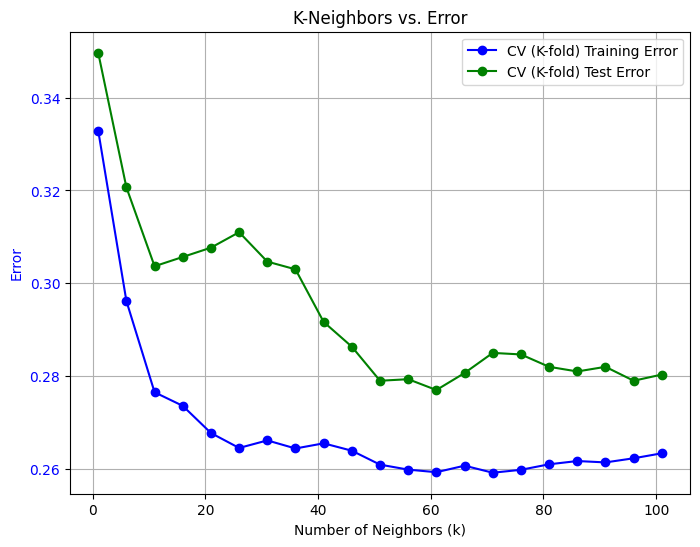

In [16]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response


X_train_stand, Y_train_stand,X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)


K = 101
train_error = []
test_error = []
for k in range(1,K+1,5):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_stand, Y_train.values.ravel())
  train_predictions = knn.predict(X_train_stand)
  test_predictions = knn.predict(X_test_stand)

  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  train_score = 1 - model_selection.cross_val_score(knn,X_train_stand, Y_train.astype(int).values.ravel(), cv=cv, scoring='accuracy').mean()
  test_score = 1 - model_selection.cross_val_score(knn,X_test_stand, Y_test.astype(int).values.ravel(), cv=cv, scoring='accuracy').mean()

  # train_error.append(1 - accuracy_score(y_true=Y_train.values.ravel(), y_pred=train_predictions))
  train_error.append(train_score)
  # test_error.append(1 - accuracy_score(y_true=Y_test.values.ravel(), y_pred=test_predictions))
  test_error.append(test_score)
  

  # # Create a plot with dual y-axes
plt.close('all') 
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot MSE on the first y-axis
ax1.plot(range(1,K+1,5), train_error, 'b-', marker='o', label='CV (K-fold) Training Error')
ax1.set_xlabel('Number of Neighbors (k)')
ax1.set_ylabel('Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax1.plot(range(1,K+1,5), test_error, 'g-', marker='o', label='CV (K-fold) Test Error')
ax1.set_xlabel('Number of Neighbors (k)')
#ax1.set_ylabel('Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.legend()
plt.grid()
plt.title("K-Neighbors vs. Error")
plt.savefig("K-Neighbors vs. Error.png", format="png", dpi=300)

# knn_train_err = (train_error[12])
# knn_test_err = (test_error[12])
# print(f"Train Error: {round(knn_train_err, 4) }")
# print(f"Test Error: {round(knn_test_err, 4) }")

In [17]:
knn_train_err = (train_error[12])
knn_test_err = (test_error[12])
print(f"Train Error: {round(knn_train_err, 4) }")
print(f"Test Error: {round(knn_test_err, 4) }")

Train Error: 0.2593
Test Error: 0.277


In [18]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

X_train_stand, Y_train_stand,X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)


n1 = round(len(data)*0.9)
n2 = round(len(data)*0.1)
b = [10]
# Initialize the result DataFrame
result_df = pd.DataFrame({
    "B Cross Validations": [],
    "Average Error Rate": [],
    "Average Error Variance": []
})

for B in b:
    # Reinitialize the lists for storing metrics for each B

    test_error_rates = []
    test_accuracies = []

    for i in range(B):
        
        X_combined = pd.concat([X_train_stand, X_test_stand], axis=0)
        y_combined = pd.concat([Y_train, Y_test], axis=0).values.flatten()

        
        X_train_sample, X_test_sample, Y_train_sample, Y_test_sample = train_test_split(
            X_combined, y_combined, train_size=n1, test_size=n2, random_state=i
        )

        # Train the model on the training data
        knn = KNeighborsClassifier(n_neighbors=60)
        knn.fit(X_train_stand, Y_train.values.ravel())

        test_predictions = knn.predict(X_test_sample)



        test_predictions = (test_predictions > 0.5).astype(int)
        #lr.fit(X_train, Y_train)
        

        # Make predictions on the testing data
        
      
      

        # Calculate error rate (MSE)
        nb_test_error_rate = 1 - accuracy_score(y_true=Y_test_sample, y_pred=test_predictions)

        # Append to the lists

        test_error_rates.append(nb_test_error_rate)

    # Calculate the variance of the testing error rates after all iterations for this B
    test_error_variance = np.var(test_error_rates)

    # Calculate the averages for the current B value

    average_test_error_rate = np.mean(test_error_rates)

    
    metrics_df = pd.DataFrame({
        "B Cross Validations": [B],
        "Average Error Rate": [average_test_error_rate],
        "Average Error Variance": [test_error_variance]
    })

    
    result_df = pd.concat([result_df, metrics_df], axis=0)


result_df

,B Cross Validations,Average Error Rate,Average Error Variance
0,10.0,0.2497,0.000112


In [19]:
final_cv_result = pd.concat([final_cv_result,pd.DataFrame({
    'Model': ['KNN'],
    'Mean Test Error': [result_df["Average Error Rate"].iloc[0]],
    'Test Error Var': [result_df["Average Error Variance"].iloc[0]]
})])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.37s/it]


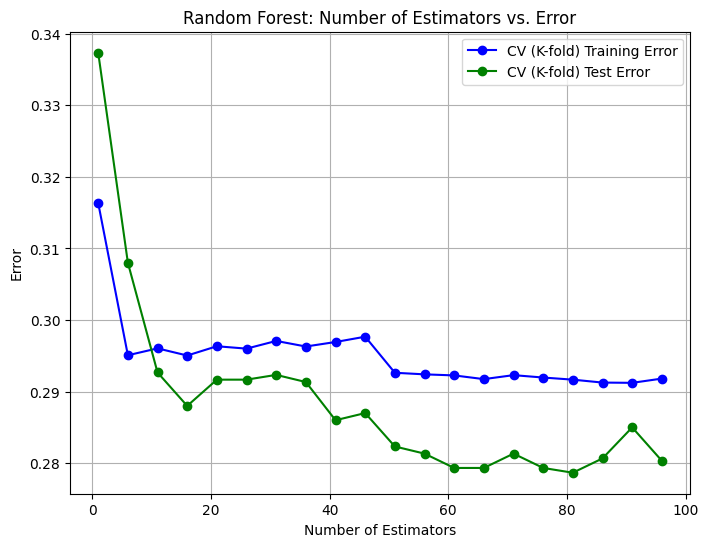

In [20]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

# Standardize Data (Assuming standardize_data() function works as expected)
X_train_stand, Y_train_stand, X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)

Y_train_stand = Y_train.values.ravel() # Ensure Y values remain binary (0/1)
Y_test_stand = Y_test.values.ravel()

# Define range of estimators (1 to 101 in steps of 5)
n_estimators_values = list(range(1, 101, 5))

# Lists to store errors
train_error = []
test_error = []

# Cross-validation setup
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Loop through different n_estimators values
for n_estimators in tqdm(n_estimators_values):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=3, random_state=42)

    # Fit the model
    rf_model.fit(X_train_stand, Y_train_stand)

    # Cross-validation scores
    train_score = 1 - cross_val_score(rf_model, X_train_stand, Y_train_stand, cv=cv, scoring='accuracy').mean()
    test_score = 1 - cross_val_score(rf_model, X_test_stand, Y_test_stand, cv=cv, scoring='accuracy').mean()

    # Append errors
    train_error.append(train_score)
    test_error.append(test_score)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_values, train_error, 'b-', marker='o', label='CV (K-fold) Training Error')
plt.plot(n_estimators_values, test_error, 'g-', marker='o', label='CV (K-fold) Test Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title("Random Forest: Number of Estimators vs. Error")
plt.legend()
plt.grid()
plt.savefig("RandomForest_NumEstimators_vs_Error.png", format="png", dpi=300)
plt.show()

In [21]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

X_train_stand, Y_train_stand,X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)


Y_train_stand = Y_train.values.ravel() # Ensure Y values remain binary (0/1)
Y_test_stand = Y_test.values.ravel()

n1 = round(len(data)*0.9)
n2 = round(len(data)*0.1)
b = [10]
# Initialize the result DataFrame
result_df = pd.DataFrame({
    "B Cross Validations": [],
    "Average Error Rate": [],
    "Average Error Variance": []
})

for B in b:
    # Reinitialize the lists for storing metrics for each B

    test_error_rates = []
    test_accuracies = []

    for i in range(B):
        
        X_combined = pd.concat([X_train_stand, X_test_stand], axis=0)
        y_combined = pd.concat([Y_train, Y_test], axis=0).values.flatten()

        
        X_train_sample, X_test_sample, Y_train_sample, Y_test_sample = train_test_split(
            X_combined, y_combined, train_size=n1, test_size=n2, random_state=i
        )

        # Train the model on the training data
        rf_model = RandomForestClassifier(n_estimators=80, max_depth=3, random_state=42)
        
        # Fit the model
        rf_model.fit(X_train_stand, Y_train_stand)

        test_predictions = rf_model.predict(X_test_sample)



        test_predictions = (test_predictions > 0.5).astype(int)
        #lr.fit(X_train, Y_train)
        

        # Make predictions on the testing data
        
      
      

        # Calculate error rate (MSE)
        nb_test_error_rate = 1 - accuracy_score(y_true=Y_test_sample, y_pred=test_predictions)

        # Append to the lists

        test_error_rates.append(nb_test_error_rate)

    # Calculate the variance of the testing error rates after all iterations for this B
    test_error_variance = np.var(test_error_rates)

    # Calculate the averages for the current B value

    average_test_error_rate = np.mean(test_error_rates)

    
    metrics_df = pd.DataFrame({
        "B Cross Validations": [B],
        "Average Error Rate": [average_test_error_rate],
        "Average Error Variance": [test_error_variance]
    })

    
    result_df = pd.concat([result_df, metrics_df], axis=0)


result_df

,B Cross Validations,Average Error Rate,Average Error Variance
0,10.0,0.2869,0.000169


In [22]:
final_cv_result = pd.concat([final_cv_result,pd.DataFrame({
    'Model': ['Random Forest'],
    'Mean Test Error': [result_df["Average Error Rate"].iloc[0]],
    'Test Error Var': [result_df["Average Error Variance"].iloc[0]]
})])

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:35<00:00,  6.23s/it]


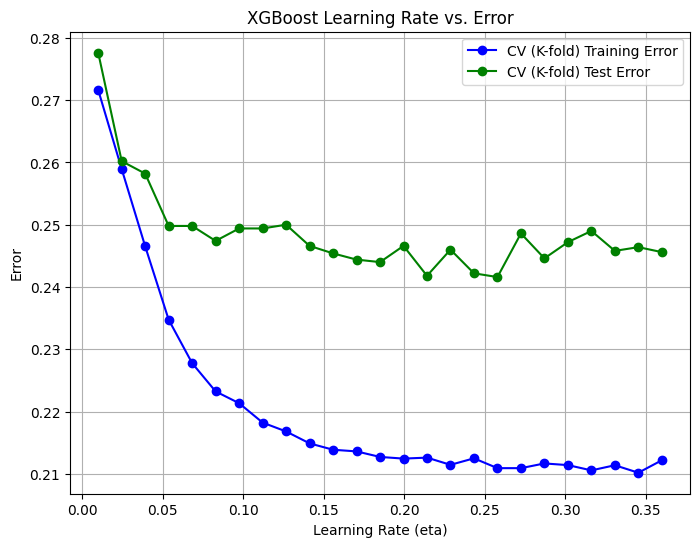

In [23]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

# Standardize Data (Assuming standardize_data() function works as expected)
X_train_stand, Y_train_stand, X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)

Y_train_stand = Y_train
Y_test_stand = Y_test

# Define range of learning rates (eta)
eta_values = np.linspace(0.01, 0.36, 25)  # From 0.01 to 0.3 in 10 steps

# Lists to store errors
train_error = []
test_error = []

# Cross-validation setup
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Loop through different eta values
for eta in tqdm(eta_values):
    xgb_model = xgb.XGBClassifier(learning_rate=eta, n_estimators=80, max_depth=3, random_state=42, eval_metric="error")

    # Fit the model
    xgb_model.fit(X_train_stand, Y_train_stand)

    # Cross-validation scores
    train_score = 1 - cross_val_score(xgb_model, X_train_stand, Y_train_stand, cv=cv, scoring='accuracy').mean()
    test_score = 1 - cross_val_score(xgb_model, X_test_stand, Y_test_stand, cv=cv, scoring='accuracy').mean()

    # Append errors
    train_error.append(train_score)
    test_error.append(test_score)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(eta_values, train_error, 'b-', marker='o', label='CV (K-fold) Training Error')
plt.plot(eta_values, test_error, 'g-', marker='o', label='CV (K-fold) Test Error')
plt.xlabel('Learning Rate (eta)')
plt.ylabel('Error')
plt.title("XGBoost Learning Rate vs. Error")
plt.legend()
plt.grid()
plt.savefig("XGBoost_LearningRate_vs_Error.png", format="png", dpi=300)
plt.show()

In [39]:
xgb_model = xgb.XGBClassifier(learning_rate=.21, n_estimators=80, max_depth=3, random_state=42, eval_metric="error")

# Fit the model
xgb_model.fit(X_train_stand, Y_train_stand)

# Cross-validation scores
train_score = 1 - cross_val_score(xgb_model, X_train_stand, Y_train_stand, cv=cv, scoring='accuracy').mean()
test_score = 1 - cross_val_score(xgb_model, X_test_stand, Y_test_stand, cv=cv, scoring='accuracy').mean()

print("train: : " ,train_score)
print("test: : " ,test_score)

train: :  0.21211111111111114
test: :  0.24760000000000015


In [24]:
X_train = train_features
Y_train = train_response
X_test = test_features
Y_test = test_response

X_train_stand, Y_train_stand,X_train_stand_scaler, Y_train_stand_scaler = standardize_data(features=X_train, response=Y_train)
X_test_stand, Y_test_stand, X_test_stand_scaler, Y_test_stand_scaler = standardize_data(features=X_test, response=Y_test)


Y_train_stand = Y_train# Ensure Y values remain binary (0/1)
Y_test_stand = Y_test

n1 = round(len(data)*0.9)
n2 = round(len(data)*0.1)
b = [100]
# Initialize the result DataFrame
result_df = pd.DataFrame({
    "B Cross Validations": [],
    "Average Error Rate": [],
    "Average Error Variance": []
})

for B in tqdm(b):
    # Reinitialize the lists for storing metrics for each B

    test_error_rates = []
    test_accuracies = []

    for i in range(B):
        
        X_combined = pd.concat([X_train_stand, X_test_stand], axis=0)
        y_combined = pd.concat([Y_train, Y_test], axis=0).values.flatten()

        
        X_train_sample, X_test_sample, Y_train_sample, Y_test_sample = train_test_split(
            X_combined, y_combined, train_size=n1, test_size=n2, random_state=i
        )

        # Train the model on the training data
        xgb_model = xgb.XGBClassifier(learning_rate=.21, n_estimators=80, max_depth=3, random_state=42, eval_metric="error")
        
        # Fit the model
        xgb_model.fit(X_train_stand, Y_train_stand)

        test_predictions = xgb_model.predict(X_test_sample)



        test_predictions = (test_predictions > 0.5).astype(int)
        #lr.fit(X_train, Y_train)
        

        # Make predictions on the testing data
        
      
      

        # Calculate error rate (MSE)
        nb_test_error_rate = 1 - accuracy_score(y_true=Y_test_sample, y_pred=test_predictions)

        # Append to the lists

        test_error_rates.append(nb_test_error_rate)

    # Calculate the variance of the testing error rates after all iterations for this B
    test_error_variance = np.var(test_error_rates)

    # Calculate the averages for the current B value

    average_test_error_rate = np.mean(test_error_rates)

    
    metrics_df = pd.DataFrame({
        "B Cross Validations": [B],
        "Average Error Rate": [average_test_error_rate],
        "Average Error Variance": [test_error_variance]
    })

    
    result_df = pd.concat([result_df, metrics_df], axis=0)


result_df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]


,B Cross Validations,Average Error Rate,Average Error Variance
0,100.0,0.18749,0.00016


In [25]:
final_cv_result = pd.concat([final_cv_result,pd.DataFrame({
    'Model': ['XGBoost'],
    'Mean Test Error': [result_df["Average Error Rate"].iloc[0]],
    'Test Error Var': [result_df["Average Error Variance"].iloc[0]]
})])

In [26]:
final_cv_result

,Model,Mean Test Error,Test Error Var
0,Logistic Regression,0.20830,0.000179
0,KNN,0.24970,0.000112
0,Random Forest,0.28690,0.000169
0,XGBoost,0.18749,0.000160


In [27]:
# X_train = train_features
# Y_train = train_response
# X_test = test_features
# Y_test = test_response

# #model = LinearRegression()

# sfs = SequentialFeatureSelector(estimator = linear_model.LinearRegression(),
#                                 k_features='best',
#                                 forward=True,
#                                 floating = True,
#                                 scoring=aic_score,
#                                 cv=None)
# selected_features = sfs.fit(X_train, Y_train)
# selected_features = list(sfs.k_feature_names_)

# X_train_stepwise = X_train[selected_features]
# X_test_stepwise = X_test[selected_features]

# X_train_stepwise = sm.add_constant(X_train_stepwise)
# X_test_stepwise = sm.add_constant(X_test_stepwise)

# lr_stepwise = sm.OLS(Y_train, X_train_stepwise).fit()

# train_predictions = lr_stepwise.predict(X_train_stepwise)
# test_predictions = lr_stepwise.predict(X_test_stepwise)


# lr_stepwise_train_mse = mean_squared_error(y_true=Y_train.values, y_pred=train_predictions)
# lr_stepwise_test_mse = mean_squared_error(y_true=Y_test.values, y_pred=test_predictions)

# print(lr_stepwise.summary())

# print(f"Train MSE: {round(lr_stepwise_train_mse, 4) }")
# print(f"Test MSE: {round(lr_stepwise_test_mse, 4) }")

In [28]:
Y_test_probs = logit.predict(X_test_stand)  # Use probability scores

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")

# Save and show plot
plt.grid(True)
plt.savefig("roc_curve.png", format="png", dpi=300)
plt.show()

knn = KNeighborsClassifier(n_neighbors=60)
knn.fit(X_train_stand, Y_train.values.ravel())
Y_test_probs = knn.predict(X_test_stand)


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")

# Save and show plot
plt.grid(True)
plt.savefig("roc_curve.png", format="png", dpi=300)
plt.show()
rf_model = RandomForestClassifier(n_estimators=80, max_depth=3, random_state=42)

# Fit the model
rf_model.fit(X_train_stand, Y_train_stand)
Y_test_probs = rf_model.predict(X_test_stand)


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forrest ROC Curve')
plt.legend(loc="lower right")

# Save and show plot
plt.grid(True)
plt.savefig("roc_curve.png", format="png", dpi=300)
plt.show()
xgb_model = xgb.XGBClassifier(learning_rate=.21, n_estimators=80, max_depth=3, random_state=42, eval_metric="error")

# Fit the model
xgb_model.fit(X_train_stand, Y_train_stand)
Y_test_probs = xgb_model.predict(X_test_stand)


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")

# Save and show plot
plt.grid(True)
plt.savefig("roc_curve.png", format="png", dpi=300)
plt.show()

ValueError: shapes (1000,11) and (12,) not aligned: 11 (dim 1) != 12 (dim 0)